首先对在BTCUSD中效果较好的CMO策略尝试参数调整
尝试通过改变freq的参数来调整策略，但无论如何调整，CMO策略的win_ratio始终处于低位，这意味着对一个具有明显下降趋势的价格序列来说，超买超卖的策略失效，需要更换其他因子来使用。

Initialize dataview success.


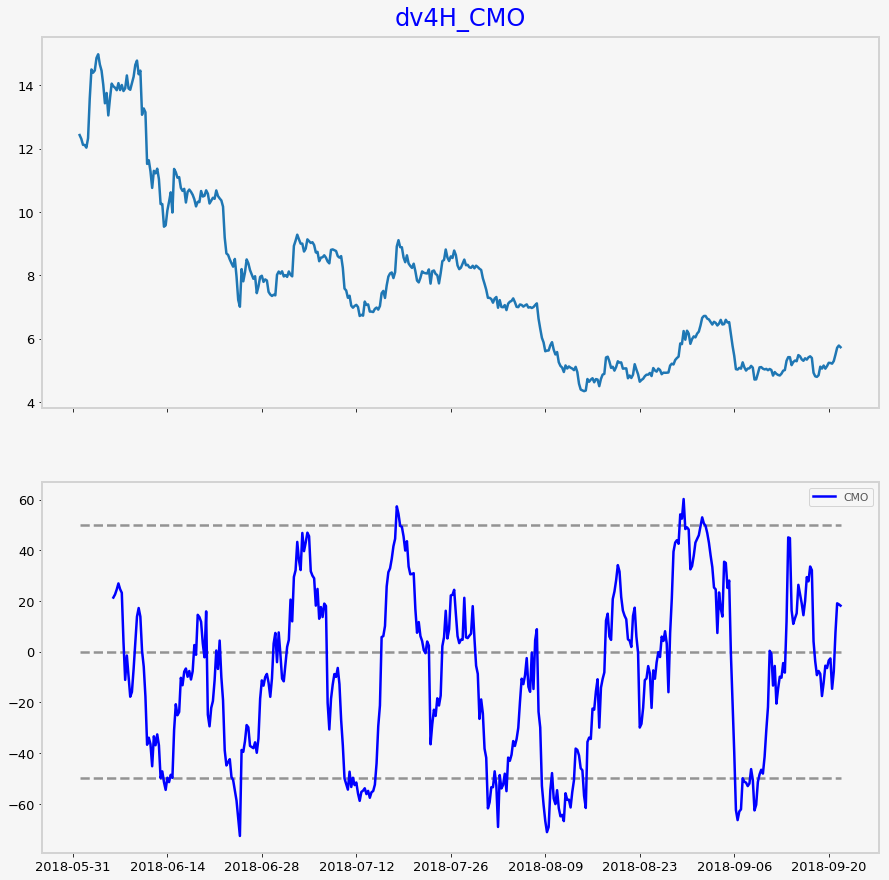

Nan Data Count (should be zero) : 0;  Percentage of effective data: 4%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 0%
*****-Summary-*****
Event Analysis
                      win    loss     all
t-stat              2.035  -9.789  -0.376
p-value             0.179   0.000   0.712
mean                0.222  -0.067  -0.013
std                 0.154   0.024   0.133
info_ratio          1.439  -2.826  -0.097
skewness           -0.690   0.952   2.092
kurtosis           -1.500   1.775   2.697
pct5                0.036  -0.096  -0.092
pct25               0.160  -0.077  -0.075
pct50               0.316  -0.075  -0.064
pct75               0.330  -0.054  -0.041
pct95               0.342  -0.034   0.323
occurance           3.000  13.000  16.000
win_ratio             NaN     NaN   0.188
win_mean/loss_mean    NaN     NaN   3.309
*****-Summary-*****
Event Analysis
                         win      loss    all
t-stat                   NaN       NaN  0.661
p-value                 

In [5]:
import warnings
from jaqs_fxdayu.data.dataservice import LocalDataService
warnings.filterwarnings('ignore')
ds = LocalDataService()

## 加freq参数
path = r'../min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high_adj,low_adj,close,volume',
         'symbol': 'EOSUSDT:binance',
         'freq': '30Min,6H',
         'start_date':20180601000000}


Time_dict = ds.bar_reader(path,props) #读取数据

from jaqs_fxdayu.data.hf_dataview import HFDataView

dv6H = HFDataView()
dv6H.create_init_dv(Time_dict['6H'].dropna().set_index(["trade_date","symbol"]))
dv6H.add_formula('SU', "Ts_Sum(If(Delta(close,1)>0,close-Delay(close, 1),0),20)" , add_data=True)  #计算SU，N=20
dv6H.add_formula('SD', "Ts_Sum(If(Delta(close,1)<0,Delay(close, 1)-close,0),20)", add_data=True) #计算SD，N=20
CMO_J = dv6H.add_formula('CMO_J', "(SU-SD)/(SU+SD)*100",  add_data=True) #利用SU和SD计算得到CMO数据



import matplotlib.pyplot as plt
import pandas as pd

import matplotlib.pyplot as plt
def Plot_CMO(dv, CMO_J, SU, SD, chart_name, n):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[-n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(CMO_J.iloc[-n:], color = 'blue',alpha=1,label='CMO')  
    #由于SU、SD与CMO数据的量纲大小不同，在图上展示后会显示不清，在这里值显示CMO的值
    #ax1.plot(SU.iloc[-n:],color = 'red',alpha=0.3,label='SU')  
    #ax1.plot(SD.iloc[-n:],color = 'green',alpha=0.3,label='SD')
    ax1.legend()
    ax1.hlines(0, CMO_J.iloc[n:].index[0], CMO_J.iloc[n:].index[-1], alpha=0.4, linestyle='--') #添加一条0线用于参考
    ax1.hlines(50, CMO_J.iloc[n:].index[0], CMO_J.iloc[n:].index[-1], alpha=0.4, linestyle='--') #添加一条50线用于参考，为超买状态
    ax1.hlines(-50, CMO_J.iloc[n:].index[0], CMO_J.iloc[n:].index[-1], alpha=0.4, linestyle='--') #添加一条-50线用于参考，为超卖状态
    plt.show()
    
CMO_J=dv6H.get_ts('CMO_J', date_type='datetime') 
SU=dv6H.get_ts('SU', date_type='datetime') 
SD=dv6H.get_ts('SD', date_type='datetime') 
Plot_CMO(dv6H, CMO_J, SU, SD, chart_name='dv4H_CMO', n=0)

#进出场信号：CMO
#进出场条件：
#只抓取超买超买点，减少交易次数
#在CMO线上穿-50线时开多，下穿50时时平多
#在CMO线下穿50线时开空，上穿-50线时平空
long = dv6H.add_formula('longCMO','If(((CMO_J>-50) && (Delay(CMO_J,1)<=-50)),2,0)',add_data = True)    
short = dv6H.add_formula('shortCMO','If(((CMO_J<50) && (Delay(CMO_J,1)>=50)),-2,0)',add_data = True)  
#出场信号
close_long = dv6H.add_formula('closeLongCMO','If(longCMO==-2,1,0)',add_data = True)
close_short = dv6H.add_formula('closeShortCMO','If(shortCMO==2,-1,0)',add_data = True)



#输出CMO因子绩效，操作与MACD类似
from jaqs_fxdayu.research import TimingDigger

def TimingSignal(td, dv, long='long', short='short', closeLong='closeLong', closeShort='closeShort', mhp=None, sl=None, sp=None):
    
    td.process_signal(
        sig_type='long',
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        price=dv.get_ts('close'),
        max_holding_period=mhp,
        stoploss=-sl,
        stopprofit=sp
    )
    
    td.process_signal(
        sig_type='short',
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        price=dv.get_ts('close'),
        max_holding_period=mhp,
        stoploss=-sl,
        stopprofit=sp
    )

tdCMO = TimingDigger(output_folder='.', output_format='pdf', signal_name='CMO_J')
TimingSignal(tdCMO, dv6H, 'longCMO', 'shortCMO', 'closeLongCMO', 'closeShortCMO', mhp=100, sl=0.05, sp=0.3)


tdCMO.create_event_report(sig_type="long")
tdCMO.create_event_report(sig_type="short")
tdCMO.create_event_report(sig_type="long_short")


接着对于适用性相对而言较好的MACD策略进行调参
发现，将freq更改为30min时，MACD策略的整体win_ratio有了提升，其中short部分的ratio接近0.5
这说明，MACD在普遍适用性上比CMO较强。
因为MACD重在分析价格趋势的持续，而CMO则抓取的是价格趋势的反转。而对于一支个股来说，其价格的变动自然与买卖量有关，但当出现持续的下行趋势时，即便是存在超买超卖现象，也不能够去有较大的反转，因而CMO策略会失效，而关注价格趋势的MACD依然保留了作用。

Initialize dataview success.


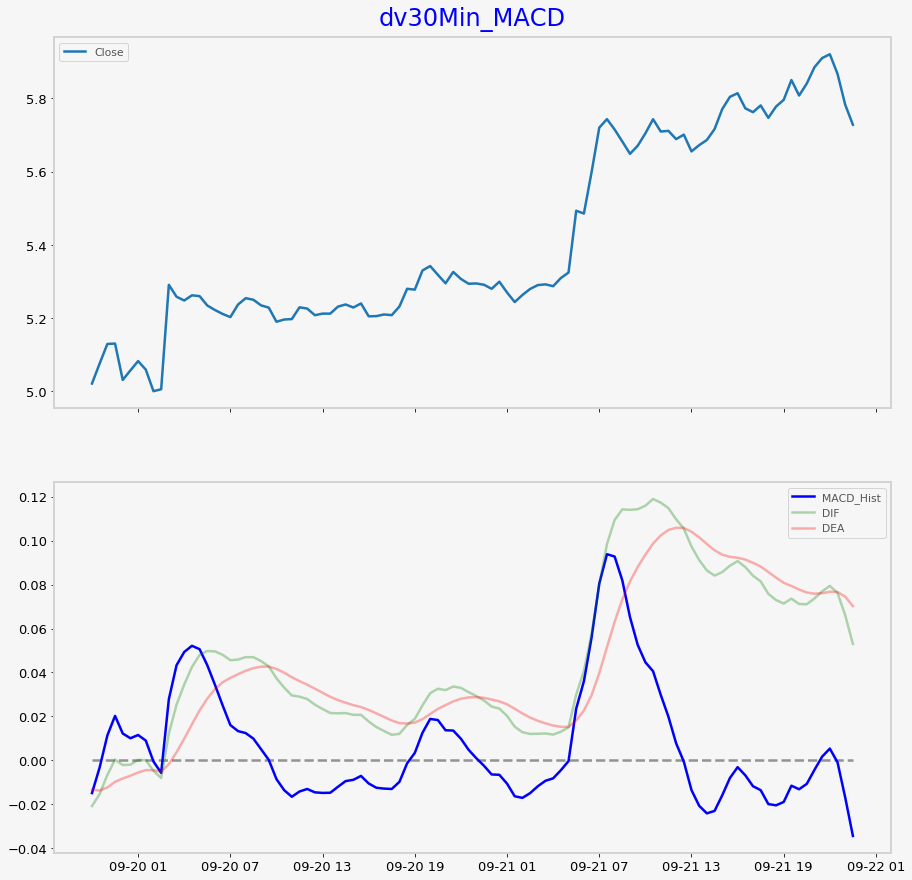

Nan Data Count (should be zero) : 0;  Percentage of effective data: 4%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 4%
*****-Summary-*****
Event Analysis
                       win     loss      all
t-stat              10.550  -32.233   -1.243
p-value              0.000    0.000    0.215
mean                 0.070   -0.053   -0.006
std                  0.056    0.018    0.070
info_ratio           1.252   -2.993   -0.091
skewness             0.574    0.701    1.114
kurtosis            -0.580    2.756    0.262
pct5                 0.004   -0.070   -0.067
pct25                0.016   -0.061   -0.057
pct50                0.068   -0.056   -0.051
pct75                0.102   -0.052    0.030
pct95                0.178   -0.013    0.136
occurance           72.000  117.000  189.000
win_ratio              NaN      NaN    0.381
win_mean/loss_mean     NaN      NaN    1.311
*****-Summary-*****
Event Analysis
                       win    loss      all
t-stat              10.4

In [6]:
import warnings
from jaqs_fxdayu.data.dataservice import LocalDataService
warnings.filterwarnings('ignore')
ds = LocalDataService()

## 加freq参数
path = r'../min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume',
         'symbol': 'EOSUSDT:binance',
         'freq': '30min,4H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props) #读取数据

from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()
dv1H.create_init_dv(Time_dict['30min'].dropna().set_index(["trade_date","symbol"]))
dv1H.add_formula('DIF',"Ta('EMA',0,0,0,0,close,0,12)-Ta('EMA',0,0,0,0,close,0,26)",add_data=True) #计算快线DIF
dv1H.add_formula('DEA',"Ta('EMA',0,0,0,0,DIF,0,9)",add_data=True)#计算DIF的9日加权移动均线DEA
dv1H.add_formula('MACD_Hist',"(DIF-DEA)*2",add_data=True)#计算MACD柱，完成因子构建


import matplotlib.pyplot as plt
import pandas as pd

#构建绘图函数来表现因子的变化与价格变化之间的关系
def Plot_MACD(dv, MACD_Hist,DIF,DEA,chart_name='dv30Min_MACD', n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))   #考虑到数据量纲不同，因此绘制2X1子图，并使用同一横轴（时间）
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:],label='Close')#获取收盘价数据
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax.legend()
    ax1.plot(MACD_Hist.iloc[n:],color='blue',alpha=1,label='MACD_Hist')
    ax1.plot(DIF.iloc[n:],color='green',alpha=0.3,label='DIF')
    ax1.plot(DEA.iloc[n:],color='red',alpha=0.3,label='DEA')
    ax1.legend()
    ax1.hlines(0, MACD_Hist.iloc[n:].index[0], MACD_Hist.iloc[n:].index[-1], alpha=0.4, linestyle='--') #添加0线作为参考线
    plt.show()


    
DIF=dv1H.get_ts('DIF', date_type='datetime') 
DEA=dv1H.get_ts('DEA', date_type='datetime') 
MACD_Hist=dv1H.get_ts('MACD_Hist', date_type='datetime') 
Plot_MACD(dv1H, MACD_Hist.iloc[:,0], DIF.iloc[:,0], DEA.iloc[:,0], n=-100)

#进出场信号：MACD
# MACD因子
#进出场条件：
#在MACD线上穿0轴时开多，下穿0轴时平多
#在MACD线下穿0轴时开空，上穿0轴时平空

#设置MACD进出场信号
long = dv1H.add_formula('longMACD','If((MACD_Hist>0) && (Delay(MACD_Hist,1)<=0),2,0)',add_data = True)    
short = dv1H.add_formula('shortMACD','If((MACD_Hist<=0) && (Delay(MACD_Hist,1)>0),-2,0)',add_data = True)  
#出场信号
close_long = dv1H.add_formula('closeLongMACD','If(longMACD==-2,1,0)',add_data = True)
close_short = dv1H.add_formula('closeShortMACD','If(shortMACD==2,-1,0)',add_data = True)


#输出MACD绩效
from jaqs_fxdayu.research import TimingDigger

def TimingSignal(td, dv, long='long', short='short', closeLong='closeLong', closeShort='closeShort', mhp=None, sl=None, sp=None):
    
    td.process_signal(
        sig_type='long',
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        price=dv.get_ts('close'),
        max_holding_period=mhp,
        stoploss=-sl,
        stopprofit=sp
    )
    
    td.process_signal(
        sig_type='short',
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        price=dv.get_ts('close'),
        max_holding_period=mhp,
        stoploss=-sl,
        stopprofit=sp
    )

tdMACD = TimingDigger(output_folder='.', output_format='pdf', signal_name='MACD_Hist')
TimingSignal(tdMACD, dv1H, 'longMACD', 'shortMACD', 'closeLongMACD', 'closeShortMACD', mhp=100, sl=0.05, sp=0.3)

tdMACD.create_event_report(sig_type="long")
tdMACD.create_event_report(sig_type="short")
tdMACD.create_event_report(sig_type="long_short")